# Конфигурация

In [1]:
import pickle

import shap

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

from implicit.cpu.als import AlternatingLeastSquares
from rectools.models.implicit_als import ImplicitALSWrapperModel

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from lightgbm import LGBMRanker

import rectools 
from rectools import Columns
from rectools.dataset import Interactions, Dataset
from rectools.model_selection import TimeRangeSplitter
from rectools.metrics import MAP, NDCG, Precision, Recall, MeanInvUserFreq, Serendipity, calc_metrics
from rectools.tools.ann import UserToItemAnnRecommender

In [2]:
K_RECOS = 10
K_RECOS_BASE = 100
RANDOM_SEED = 32

np.random.seed(RANDOM_SEED)

In [3]:
metrics = {'MAP@1': MAP(k=1), 'MAP@5': MAP(k=5), 'MAP@10': MAP(k=10),
           'NDCG@1': NDCG(k=1), 'NDCG@5': NDCG(k=5), 'NDCG@10': NDCG(k=10),
           'Precision@1': Precision(k=1), 'Precision@5': Precision(k=5), 'Precision@10': Precision(k=10),
           'Recall@1': Recall(k=1), 'Recall@5': Recall(k=5), 'Recall@10': Recall(k=10),
           'MeanInvUserFreq@1': MeanInvUserFreq(k=1), 'MeanInvUserFreq@5': MeanInvUserFreq(k=5), 'MeanInvUserFreq@10': MeanInvUserFreq(k=10),
           'Serendipity@1': Serendipity(k=1), 'Serendipity@5': Serendipity(k=5), 'Serendipity@10': Serendipity(k=10)}

In [4]:
def calc_metrics_(candidates_df, rank_col: str):
    metrics = {
        'ndcg@10': NDCG(k = 10),
        'map@10': MAP(k = 10),
        'Precision@10': Precision(k = 10),
        'recall@10': Recall(k = 10),
        'novelty@10': MeanInvUserFreq(k = 10),
    }
    return calc_metrics(
        metrics=metrics,
        reco=(
            candidates_df
            .rename(columns={rank_col: Columns.Rank})
            [[Columns.User, Columns.Item, Columns.Rank]]
            [candidates_df[Columns.User].isin(test_users)]
        ),
        interactions=(
            test
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [test[Columns.User].isin(test_users)]
        ), 
        prev_interactions=(
            base_model_data
            [[Columns.User, Columns.Item, Columns.Datetime, Columns.Weight]]
            [base_model_data[Columns.User].isin(test_users)]
        ),
        catalog=items['item_id'].unique()
    )

In [5]:
def avg_user_metric(
        y_true,
        y_pred,
        user_ids,
        metric_function,
) -> float:
    """
    Вычисляем метрику, усредненную по всем значимым (есть разные таргеты) группам.

    :param y_true: список таргетов
    :param y_pred: список предсказаний
    :param user_ids: список групп (обычно это список user_id той же размерности, что и предсказания и таргеты)
    :param metric_function: усредняемая метрика(y_true, y_pred) -> float
    :return: значение метрики metric_function, усредненное по всем значимым группам
    """
    avg_score: float = 0.

    if len(y_pred) == len(y_true) == len(user_ids):
        l_ind: int = 0
        cur_group_id: int = user_ids[0] if len(user_ids) else 0
        n_groups: int = 0
        for r_ind, group_id in enumerate(user_ids):
            if group_id != cur_group_id or r_ind == len(user_ids) - 1:
                if r_ind == len(user_ids) - 1:
                    r_ind += 1
                # Если группа не состоит из одного и того же таргета - добавляем ее
                try:
                    group_true = y_true[l_ind: r_ind]
                    if not np.all(group_true == group_true[0]):
                        avg_score += metric_function(group_true, y_pred[l_ind: r_ind])
                        n_groups += 1
                    l_ind = r_ind
                    cur_group_id = group_id
                except Exception:
                    print(group_true, y_pred[l_ind: r_ind])
        avg_score /= max(1, n_groups)
    else:
        raise ValueError(f'Размерности не совпадают: '
                         f'y_pred - {len(y_pred)}, y_true - {len(y_true)}, user_ids - {len(user_ids)}')
    return avg_score

# Загрузка данных

In [6]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

In [7]:
interactions = pd.read_csv('data_original/interactions.csv', parse_dates=["last_watch_dt"])

In [8]:
interactions.dropna(inplace=True)

In [9]:
interactions.rename(
    columns={
        'last_watch_dt': Columns.Datetime,
    }, 
    inplace=True)

Вычисление весов как индикаторов на основе процента просмотренного показывает результаты на тесте лучше, чем использование total_dur в качестве весов

In [10]:
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)

In [11]:
interactions = Interactions(interactions)

In [12]:
headtail(interactions.df)

,user_id,item_id,datetime,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,3.0
1,699317,1659,2021-05-29,8317,100.0,3.0
2,656683,7107,2021-05-09,10,0.0,1.0
3,864613,7638,2021-07-05,14483,100.0,3.0
4,964868,9506,2021-04-30,6725,100.0,3.0
5476246,648596,12225,2021-08-13,76,0.0,1.0
5476247,546862,9673,2021-04-13,2308,49.0,3.0
5476248,697262,15297,2021-08-20,18307,63.0,3.0
5476249,384202,16197,2021-04-19,6203,100.0,3.0
5476250,319709,4436,2021-08-15,3921,45.0,3.0


In [13]:
interactions.df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Index: 5475423 entries, 0 to 5476250
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   total_dur    int64         
 4   watched_pct  float64       
 5   weight       float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 292.4 MB


In [14]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

# Подготовка данных

In [15]:
users = users[users.user_id.isin(interactions.df.user_id)].copy()

In [16]:
items = items[items.item_id.isin(interactions.df.item_id)].copy()

Заполняем пропуски значением "unknown"

In [17]:
users.fillna('unknown', inplace=True)

Производится Leave-time-out разбиение -- последняя неделя на test, остальное на train

In [18]:
max_date = interactions.df['datetime'].max()

base_model_data = interactions.df[(interactions.df['datetime'] < max_date - pd.Timedelta(days=7))]
base_model_data.drop(base_model_data.query("total_dur < 300").index, inplace=True) # удаляем короткие айтемы
base_users = base_model_data[Columns.User].unique()
base_items = base_model_data[Columns.Item].unique()

test = interactions.df[interactions.df['datetime'] >= max_date - pd.Timedelta(days=7)]
base_test_users = test[Columns.User].unique()

hot_test = test[test['user_id'].isin(base_model_data['user_id'].unique())]
base_hot_test_users = hot_test[Columns.User].unique()

train_size = 0.7
val_size = 0.15
test_size = 0.15

train_val_users, test_users = train_test_split(
    test['user_id'].unique(), random_state=RANDOM_SEED, test_size=test_size
)

train_users, val_users = train_test_split(
    train_val_users, random_state=RANDOM_SEED, test_size=val_size / (train_size + val_size)  # 15% от общего размера
)

catalog = base_model_data[Columns.Item].unique()

print(f"train: {base_model_data.shape}")
print(f"hot test: {hot_test.shape}")


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


train: (3832259, 6)
hot test: (333022, 6)


In [19]:
def encode_cat_cols(df: pd.DataFrame, cat_cols):
    cat_col_encoding = {}  # словарь с категориями

    # Тут мы могли бы заполнять пропуски как еще одну категорию,
    # но они и так заполняются таким образом автоматически ниже
    # default_values = {col: 'None' for col in cat_cols}
    # df.fillna(default_values, inplace=True)

    for col in cat_cols:
        cat_col = df[col].astype('category').cat
        cat_col_encoding[col] = cat_col.categories
        df[col] = cat_col.codes.astype('category')
    return df, cat_col_encoding

В качестве фичей юзеров были выбраны: возраст, доход, пол

In [20]:
user_features_names = ["age", "income", "sex", "kids_flg"]

In [21]:
cat_user_features_names = ["age", "income", "sex", "kids_flg"]

In [22]:
users, users_cat_col_encoding = encode_cat_cols(users, cat_user_features_names)

In [23]:
user_features_frames = []
for feature in user_features_names:
    feature_frame = users.reindex(columns=["user_id", feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)

In [24]:
print('Number user features:', user_features[['value', 'feature']].groupby('feature').nunique().sum().item())

Number user features: 19


In [25]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,1,4,2,1
1,962099,0,2,2,0
3,721985,3,2,1,0
4,704055,2,4,1,0
5,1037719,3,4,2,0


В качестве фичей айтемов были выбраны: жанр, тип контента, диапазон даты выхода

In [26]:
item_features_names = ["year_bin", "genre", "content_type"]

In [27]:
cat_item_features_names = ["year_bin", "content_type", "genre"]

In [28]:
items.release_year.fillna(items.release_year.median(), inplace=True)

In [29]:
YEAR_FROM = 1990
STEP_SIZE = 5
bins = [year for year in range(YEAR_FROM, int(items['release_year'].max()) + STEP_SIZE, STEP_SIZE)]
bins = [int(items['release_year'].min())] + bins
items['year_bin'] = pd.cut(items['release_year'],
                           bins=bins, include_lowest=True)
items['year_bin'] = items['year_bin'].astype('str')

In [30]:
year_feature = items.reindex(columns=[Columns.Item, "year_bin"])
year_feature.columns = ["id", "value"]
year_feature["feature"] = "year_bin"

In [31]:
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"

In [32]:
content_feature = items.reindex(columns=[Columns.Item, "content_type"])
content_feature.columns = ["id", "value"]
content_feature["feature"] = "content_type"

In [33]:
item_features = pd.concat((year_feature, content_feature, genre_feature))

In [34]:
items, items_cat_col_encoding = encode_cat_cols(items, [feat for feat in cat_item_features_names if feat != "genre"])

In [35]:
items = items.loc[:,items.columns.isin(['item_id']+[feat for feat in cat_item_features_names if feat != "genre"])].copy()

In [36]:
print('Number item features:', item_features.value.nunique())

Number item features: 105


In [37]:
items.head()

,item_id,content_type,year_bin
0,10711,0,3
1,2508,0,5
2,10716,0,5
3,7868,0,5
4,16268,0,0


В датасет были включены фичи юзеров и айтемов

In [38]:
dataset_base = Dataset.construct(
    interactions_df=base_model_data,
    user_features_df=user_features[user_features.id.isin(base_users)],
    cat_user_features=user_features_names,
    item_features_df=item_features[item_features.id.isin(base_items)],
    cat_item_features=cat_item_features_names
)

# Обучение модели первого уровня

В качестве модели первого уровня была выбрана ALS из домашнего задания 4

In [39]:
N_FACTORS = 128
REG = 0.5
ALPHA = 10
NUM_THREADS = 12
ITERATIONS = 10

In [40]:
als = AlternatingLeastSquares(factors=N_FACTORS,
                              regularization=REG,
                              alpha=ALPHA,
                              num_threads=NUM_THREADS,
                              random_state=RANDOM_SEED,
                              iterations=ITERATIONS)

OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
Intel MKL BLAS is configured to use 6 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'MKL_NUM_THREADS=1' or by callng 'threadpoolctl.threadpool_limits(1, "blas")'. Having MKL use a threadpool can lead to severe performance issues


In [41]:
als_wrapper = ImplicitALSWrapperModel(model=als,
                                      verbose=1,
                                      fit_features_together=True)

In [42]:
%%time
als_wrapper.fit(dataset_base)

Converting sparse features to dense array may cause MemoryError


  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 5min 45s
Wall time: 33.5 s


In [43]:
# with open("als_wrapper.pkl", "wb") as file:
#     pickle.dump(als_wrapper, file)

In [44]:
with open("als_wrapper.pkl", "rb") as file:
    als_wrapper = pickle.load(file)

In [61]:
%%time
candidates = als_wrapper.recommend(users=base_users, dataset=dataset_base, k=100, filter_viewed=False)

CPU times: total: 15min 29s
Wall time: 9min 57s


In [111]:
candidates.rename(columns={'score':'als_score', 'rank':'als_rank'}, inplace=True)

In [113]:
# candidates.to_csv('candidates.csv', index=False)

In [41]:
candidates = pd.read_csv('candidates.csv')

In [42]:
candidates.head()

,user_id,item_id,als_score,als_rank
0,176549,13018,1.224283,1
1,176549,9728,1.192740,2
2,176549,14317,1.077546,3
3,176549,16166,1.075970,4
4,176549,10761,1.059111,5


In [47]:
models_metrics = dict()

In [48]:
models_metrics['ALS'] = calc_metrics_(candidates, 'als_rank')

In [49]:
pd.DataFrame(models_metrics)

,ALS
Precision@10,0.018095
map@10,0.032450
ndcg@10,0.020471
novelty@10,3.818135
recall@10,0.084091


# Подготовка данных для модели второго уровня

In [43]:
# Получаем длину истории юзера
base_model_data['user_hist'] = (
    base_model_data.groupby('user_id')
    ['item_id'].transform('count')
)

# Получаем популярность контента
base_model_data['item_pop'] = (
    base_model_data.groupby('item_id')
    ['user_id'].transform('count')
)

# Получаем среднюю популярность контента, просматриваемого этим юзером
base_model_data['user_avg_pop'] = (
    base_model_data.groupby('user_id')
    ['item_pop'].transform('mean')
)

# Получаем среднюю длину истории пользователя, которые смотрит этот контент
base_model_data['item_avg_hist'] = (
    base_model_data.groupby('item_id')
    ['user_hist'].transform('mean')
)

# Получаем популярность последнего просмотренного контента
base_model_data.sort_values(
    by=[Columns.User, Columns.Datetime], 
    ascending=[True, False], 
    ignore_index=True,
    inplace=True,
)

base_model_data['user_last_pop'] = (
    base_model_data.groupby('user_id')
    ['item_pop'].transform('first')
)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [44]:
base_model_data.head()

,user_id,item_id,datetime,total_dur,watched_pct,weight,user_hist,item_pop,user_avg_pop,item_avg_hist,user_last_pop
0,0,15297,2021-07-19,459,0.0,1.0,1,158315,158315.000000,6.998566,158315
1,1,10440,2021-08-13,19579,80.0,3.0,1,159230,159230.000000,7.490649,159230
2,2,16029,2021-06-26,5453,100.0,3.0,45,1116,3045.444444,27.879032,1116
3,2,13867,2021-06-24,5658,100.0,3.0,45,1954,3045.444444,25.355169,1116
4,2,9164,2021-06-23,6650,100.0,3.0,45,3030,3045.444444,22.819142,1116


In [45]:
# Добавляем новые фичи в соответствующие таблицы

items = pd.merge(
    left=items, 
    right=(
        base_model_data
        [['item_id', 'item_pop', 'item_avg_hist']]
        .drop_duplicates()
    ),
    how='left',
    on='item_id',
)

users = pd.merge(
    left=users, 
    right=(
        base_model_data
        [['user_id', 'user_hist', 'user_avg_pop', 'user_last_pop']]
        .drop_duplicates()
    ),
    how='left',
    on='user_id',
)

In [46]:
items.head(3)

,item_id,content_type,year_bin,item_pop,item_avg_hist
0,10711,0,3,3.0,87.000000
1,2508,0,5,7.0,27.000000
2,10716,0,5,6.0,55.333333


In [120]:
# items.to_csv('items_processed.csv', index=False)

In [47]:
users.head(3)

,user_id,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop
0,973171,1,4,2,1,4.0,1134.250000,742.0
1,962099,0,2,2,0,13.0,1329.000000,324.0
2,721985,3,2,1,0,14.0,7056.857143,2790.0


In [121]:
# users.to_csv('users_processed.csv', index=False)

In [48]:
# Делаем дефолтные значения

default_values_items = {}

# Для новых фичей айтемов
default_values_items['item_pop'] = base_model_data['item_pop'].median()
default_values_items['item_avg_hist'] = base_model_data['item_avg_hist'].median()

# Для старых фичей взаимодействий
interactions_default_values = {
    Columns.Datetime: interactions.df[Columns.Datetime].median(),
    'watched_pct': 0,
    Columns.Weight: 1,
    'total_dur': 0,
}

# Для новых фичей юзеров
default_values_users = {
    'user_hist': 0,
    'user_avg_pop': base_model_data['user_avg_pop'].median(),
    'user_last_pop': base_model_data['user_last_pop'].median(),
}

In [ ]:
# with open('default_values_items.pkl', 'wb') as f:
#     pickle.dump(default_values_items, f)

In [49]:
# with open('default_values_users.pkl', 'wb') as f:
#     pickle.dump(default_values_users, f)

In [56]:
# Оставляем среди юзеров только тех, для кого есть и рекомы и таргеты

def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='right',
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['als_score'].min() - 0.01
    max_rank: int = df['als_rank'].max() + 1  # 101
    
    default_values = {
        'als_score': min_score, 'als_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

ranker_train = users_filter(train_users, candidates, test)
ranker_val = users_filter(val_users, candidates, test)
ranker_test = users_filter(test_users, candidates, test)

In [57]:
# Добавляем фичи
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

ranker_train = add_features(ranker_train)
ranker_val = add_features(ranker_val)
ranker_test = add_features(ranker_test)

In [58]:
ranker_train.head(3)

,user_id,item_id,datetime,total_dur,watched_pct,weight,als_score,als_rank,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,content_type,year_bin,item_pop,item_avg_hist
0,1,14,2021-07-01,0.0,0.0,1.0,0.081404,51,1,2,1,1,1.0,159230.0,159230.0,1,6,5667.0,13.941239
1,1,24,2021-07-01,0.0,0.0,1.0,0.079122,54,1,2,1,1,1.0,159230.0,159230.0,1,6,4861.0,17.187821
2,1,101,2021-07-01,0.0,0.0,1.0,0.113103,31,1,2,1,1,1.0,159230.0,159230.0,0,6,6661.0,17.013361


In [59]:
cols = [
    'als_score', 'als_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'year_bin', 'item_pop', 'item_avg_hist',
]

cat_cols = cat_user_features_names + [feat for feat in cat_item_features_names if feat != "genre"]

# Обучение модели второго уровня

In [60]:
def get_group(df: pd.DataFrame) -> np.ndarray:
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [61]:
def add_target(df: pd.DataFrame) -> pd.DataFrame:
    """
    0 - доля досмотра < 0.15
    1 - 0.15 <= доля досмотра < 0.75
    2 - 0.75 <= доля досмотра
    """
    df['target_ranker'] = (df['watched_pct'] >= 15).astype(int)
    df['target_ranker'] += (df['watched_pct'] >= 75).astype(int)
    return df

In [62]:
ranker_train = add_target(ranker_train)
ranker_val = add_target(ranker_val)
ranker_test = add_target(ranker_test)

In [63]:
early_stopping_rounds = 32

params = {
    'objective': 'lambdarank',  # lambdarank, оптимизирующий ndcg 
    'n_estimators': 10000,  # максимальное число деревьев
    'max_depth': 4,  # максимальная глубина дерева
    'num_leaves': 10,  # число листьев << 2^max_depth
    'min_child_samples': 100,  # число примеров в листе
    'learning_rate': 0.25,  # шаг обучения
    'reg_lambda': 1,  # L2 регуляризация
    'colsample_bytree': 0.9,  # доля колонок, которая используется в каждом дереве
    'early_stopping_rounds': early_stopping_rounds,  # число итераций, в течение которых нет улучшения метрик
    'verbose': early_stopping_rounds // 8,  # период вывода метрик
    'random_state': 42,
}

fit_params = {
    'X': ranker_train[cols],
    'y': ranker_train['target_ranker'],
    'group': get_group(ranker_train),
    'eval_set': [(ranker_val[cols], ranker_val['target_ranker'])],
    'eval_group': [get_group(ranker_val)],
    'eval_metric': 'ndcg',
    'eval_at': (3, 5, 10),
    'categorical_feature': cat_cols,
    'feature_name': cols,
}

In [64]:
listwise_model = LGBMRanker(**params)
listwise_model.fit(**fit_params)

[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.128763
[LightGBM] [Debug] init for col-wise cost 0.000219 seconds, init for row-wise cost 0.249316 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1566
[LightGBM] [Info] Number of data points in the train set: 7906800, number of used features: 13
[LightGBM] [Warning] early_stopping_round is set=32, early_stopping_rounds=32 will be ignored. Current value: early_stopping_round=32
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
Training until validation scores don't improve for 32 rounds
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 10 and depth = 4
[LightGB

LGBMRanker(colsample_bytree=0.9, early_stopping_rounds=32, learning_rate=0.25,
           max_depth=4, min_child_samples=100, n_estimators=10000,
           num_leaves=10, objective='lambdarank', random_state=42, reg_lambda=1,
           verbose=4)

In [65]:
# with open('listwise_model.pkl', 'wb') as f:
#     pickle.dump(listwise_model, f)

In [66]:
with open("listwise_model.pkl", "rb") as file:
    listwise_model = pickle.load(file)

In [67]:
listwise_model.best_score_['valid_0']

OrderedDict([('ndcg@3', 0.6920874212791068),
             ('ndcg@5', 0.7068154792933988),
             ('ndcg@10', 0.724674795658147)])

In [68]:
explainer = shap.Explainer(listwise_model)
shap_values = explainer(ranker_test[cols].iloc[:10_000])

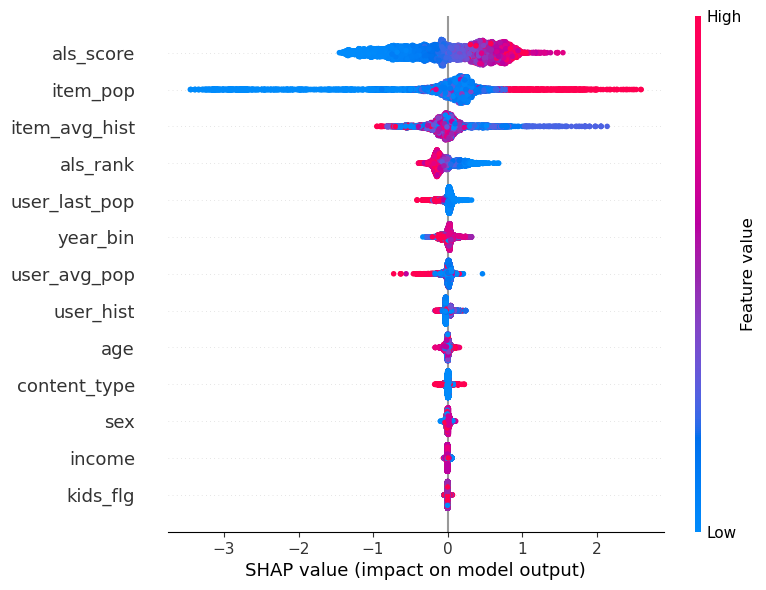

In [69]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values, max_display=len(cols))

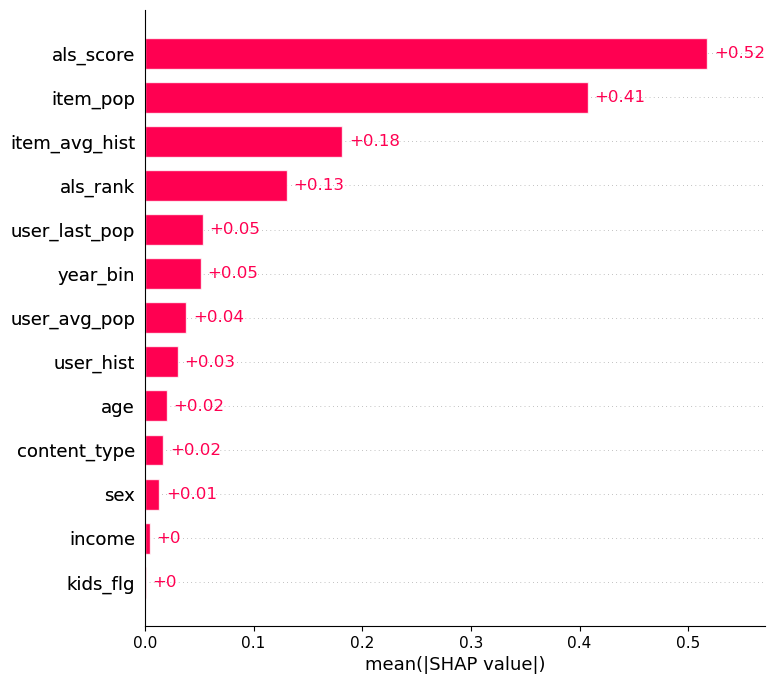

In [70]:
# mean shap-values
shap.plots.bar(shap_values, max_display=len(cols))

In [71]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    return df

In [72]:
listwise_pred = listwise_model.predict(ranker_test[cols])
ranker_test = add_score_and_rank(ranker_test, listwise_pred, 'listwise')

In [73]:
ranker_test.head(3)

,user_id,item_id,datetime,total_dur,watched_pct,weight,als_score,als_rank,age,income,...,user_hist,user_avg_pop,user_last_pop,content_type,year_bin,item_pop,item_avg_hist,target_ranker,listwise_score,listwise_rank
63,75,9728,2021-07-01,0.0,0.0,1.0,0.564226,2,1,3,...,1.0,21010.0,21010.0,0,7,92359.0,11.062409,0,1.704158,1
88,75,13865,2021-07-01,0.0,0.0,1.0,0.475130,3,1,3,...,1.0,21010.0,21010.0,0,7,96838.0,10.242642,0,1.322319,2
22,75,3734,2021-07-01,0.0,0.0,1.0,0.400235,4,1,3,...,1.0,21010.0,21010.0,0,7,61313.0,11.761160,0,1.112818,3


# Раcчёт метрик

In [74]:
models_metrics['listwise'] = calc_metrics_(ranker_test, 'listwise_rank')

In [75]:
pd.DataFrame(models_metrics)

,ALS,listwise
Precision@10,0.018095,0.022599
recall@10,0.084091,0.107492
ndcg@10,0.020471,0.027469
map@10,0.032450,0.049008
novelty@10,3.818135,3.581891


# Инференс для сервиса

Из-за недостатка оперативной памяти при инференсе все фичи были сохранены на диск и для формирования датасета для инференса нужны только вычисляются только интеракции модели первого уровня (base_model_data)

In [19]:
def users_filter(
    user_list: np.ndarray,
    candidates_df: pd.DataFrame, 
    df: pd.DataFrame,
) -> pd.DataFrame:
    # Джойним интеракции на наших кандидатов для юзеров из трейна, вал и теста
    df = pd.merge(
        df[df['user_id'].isin(user_list)], 
        candidates_df[candidates_df['user_id'].isin(user_list)], 
        how='right',
        on=['user_id', 'item_id']
    )
    # Проставляем дефолтные значения интеракций
    min_score: float =  df['als_score'].min() - 0.01
    max_rank: int = df['als_rank'].max() + 1  # 101
    
    default_values = {
        'als_score': min_score, 'als_rank': max_rank,
        # Важно использовате те же дефолтные значения для интеракций, 
        # чтобы не сделать утечку
        **interactions_default_values,
    }
    df.fillna(default_values, inplace=True)
        
    # Сортируем по user_id - это пригодится для вычисления рангов и групп для ранжирования
    df.sort_values(
        by=['user_id', 'item_id'],
        inplace=True,
    )
    return df

In [20]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = pd.merge(
        df, 
        users, 
        how='left', 
        on=['user_id']
    )
    df = pd.merge(
        df, 
        items, 
        how='left', 
        on=['item_id']
    )

    df.fillna(default_values_items, inplace=True)
    df.fillna(default_values_users, inplace=True)

    # Категориальные фичи закодированы пандасом так, что None === -1
    # Если изначально пропусков не было, то нужно добавить такое значение категории
    for col in df.columns:
        if isinstance(df[col].dtype, pd.CategoricalDtype):
            if -1 not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(-1)
            df.fillna({col: -1}, inplace=True)
    return df

In [21]:
def add_score_and_rank(df: pd.DataFrame, y_pred_scores: np.ndarray, name: str) -> pd.DataFrame:
    # Добавляем скор модели второго уровня
    df[f'{name}_score'] = y_pred_scores
    # Добавляем ранг модели второго уровня
    df.sort_values(
        by=['user_id', f'{name}_score'],
        ascending=[True, False],
        inplace=True,
    )
    df[f'{name}_rank'] = df.groupby('user_id').cumcount() + 1

    return df

In [22]:
candidates = pd.read_csv('candidates.csv')

In [23]:
items = pd.read_csv('items_processed.csv')

In [24]:
users = pd.read_csv('users_processed.csv')

In [25]:
with open("default_values_items.pkl", "rb") as file:
    default_values_items = pickle.load(file)

In [26]:
with open("default_values_users.pkl", "rb") as file:
    default_values_users = pickle.load(file)

In [27]:
interactions_default_values = {
    Columns.Datetime: interactions.df[Columns.Datetime].median(),
    'watched_pct': 0,
    Columns.Weight: 1,
    'total_dur': 0,
}

In [41]:
cols = [
    'als_score', 'als_rank', 
    'age', 'income', 'sex', 'kids_flg', 'user_hist', 'user_avg_pop', 'user_last_pop',
    'content_type', 'year_bin', 'item_pop', 'item_avg_hist',
]

cat_cols = ['age', 'income', 'sex', 'kids_flg', 'year_bin', 'content_type']

In [30]:
# Джоиним кандидатов к чистым интерациям
ranker_inference = users_filter(base_users,
                                candidates,
                                base_model_data)

In [31]:
ranker_inference.head()

,user_id,item_id,datetime,total_dur,watched_pct,weight
0,176549,9506,2021-05-11,4250,72.0,3.0
1,699317,1659,2021-05-29,8317,100.0,3.0
3,864613,7638,2021-07-05,14483,100.0,3.0
4,964868,9506,2021-04-30,6725,100.0,3.0
5,1032142,6686,2021-05-13,11286,100.0,3.0


In [32]:
# Добавляем фичи айтемов и юзеров
ranker_inference = add_features(ranker_inference)

In [34]:
ranker_inference.head()

,user_id,item_id,datetime,total_dur,watched_pct,weight,als_score,als_rank,age,income,sex,kids_flg,user_hist,user_avg_pop,user_last_pop,content_type,year_bin,item_pop,item_avg_hist
0,0,14,2021-07-01,0.0,0.0,1.0,0.094465,34,5.0,2.0,1.0,0.0,1.0,158315.0,158315.0,1,6,5667.0,13.941239
1,0,24,2021-07-01,0.0,0.0,1.0,0.050167,65,5.0,2.0,1.0,0.0,1.0,158315.0,158315.0,1,6,4861.0,17.187821
2,0,101,2021-07-01,0.0,0.0,1.0,0.102727,29,5.0,2.0,1.0,0.0,1.0,158315.0,158315.0,0,6,6661.0,17.013361
3,0,142,2021-07-01,0.0,0.0,1.0,0.143412,14,5.0,2.0,1.0,0.0,1.0,158315.0,158315.0,0,6,35213.0,14.643938
4,0,372,2021-07-01,0.0,0.0,1.0,0.037956,85,5.0,2.0,1.0,0.0,1.0,158315.0,158315.0,0,5,2312.0,22.791955


In [56]:
for col in cat_cols:
    ranker_inference[col] = ranker_inference[col].astype('category')

In [46]:
with open("listwise_model.pkl", "rb") as file:
    listwise_model = pickle.load(file)

In [58]:
listwise_pred = listwise_model.predict(ranker_inference[cols])
ranker_inference = add_score_and_rank(ranker_inference, listwise_pred, 'listwise')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [61]:
ranker_inference_10 = ranker_inference.groupby('user_id').head(10)

In [62]:
# ranker_inference_10.to_csv('ranker_inference_10.csv', index=False)

In [64]:
ranker_recos = ranker_inference_10.groupby('user_id')['item_id'].agg(list).reset_index()

In [65]:
# ranker_recos.to_pickle('ranker_inference_10.pkl')

In [66]:
ranker_recos.head()

,user_id,item_id
0,0,"[9728, 10440, 13865, 3734, 15297, 4151, 512, 1..."
1,1,"[15297, 9728, 3734, 13865, 4151, 12192, 142, 8..."
2,2,"[9728, 3182, 5411, 7582, 11749, 11790, 16166, ..."
3,3,"[12192, 15297, 10440, 7793, 9728, 5434, 3734, ..."
4,4,"[15297, 9728, 13865, 10440, 3734, 4151, 8636, ..."


In [70]:
# with open('ranker_user_ids.pkl', 'wb') as f:
#     pickle.dump(set(ranker_recos.user_id), f)